In [313]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import os

import time

import scipy.stats as stats

import pulp

import unidecode

Loading the data from the files

In [314]:
folderpath = 'data/'

players_1617_df = pd.read_csv(folderpath+'2016-17/players_raw.csv')
players_1718_df = pd.read_csv(folderpath+'2017-18/players_raw.csv')
players_1819_df = pd.read_csv(folderpath+'2018-19/players_raw.csv')
players_1920_df = pd.read_csv(folderpath+'2019-20/players_raw.csv')
players_2021_df = pd.read_csv(folderpath+'2020-21/players_raw.csv')
players_2122_df = pd.read_csv(folderpath+'2021-22/players_raw.csv')
players_2223_df = pd.read_csv(folderpath+'2022-23/players_raw.csv')
players_2324_df = pd.read_csv(folderpath+'2023-24/players_raw.csv')

gws_1617_df = pd.read_csv(folderpath+'2016-17/gws/merged_gw.csv', encoding='latin')
gws_1718_df = pd.read_csv(folderpath+'2017-18/gws/merged_gw.csv', encoding='latin')
gws_1819_df = pd.read_csv(folderpath+'2018-19/gws/merged_gw.csv', encoding='latin')
gws_1920_df = pd.read_csv(folderpath+'2019-20/gws/merged_gw.csv', encoding='latin')
gws_2021_df = pd.read_csv(folderpath+'2020-21/gws/merged_gw.csv', encoding='latin')
gws_2122_df = pd.read_csv(folderpath+'2021-22/gws/merged_gw.csv', encoding='latin')
gws_2223_df = pd.read_csv(folderpath+'2022-23/gws/merged_gw.csv', encoding='latin')
gws_2324_df = pd.read_csv(folderpath+'2023-24/gws/merged_gw.csv', encoding='latin')

team_codes_df = pd.read_csv(folderpath+'teams.csv')
team_codes_df.columns.values[2:] = team_codes_df.columns[2:].str.replace('team_', '')

## Clean and process the dataframes

We want to add:
- Player Position
- Full Name (names are inconsistent across seasons and between df's)

We will also remove `Danny Ward` as there were two in the 18/19 season, both has 0 points so no harm in removing them.

In [315]:
# remove Danny Wards from 18/19 season
players_1819_df = players_1819_df[((players_1819_df.first_name == "Danny") & (players_1819_df.second_name=="Ward"))==False]
gws_1819_df = gws_1819_df[gws_1819_df.name.str.contains("Danny_Ward")==False]

Here we are adding the seasons onto the df

In [316]:
player_df_list = [players_1617_df, players_1718_df, players_1819_df, players_1920_df, players_2021_df, players_2122_df, players_2223_df, players_2324_df]
gw_df_list = [gws_1617_df, gws_1718_df, gws_1819_df, gws_1920_df, gws_2021_df, gws_2122_df, gws_2223_df, gws_2324_df]

# append season and season index to dfs

seasons = ['1617', '1718', '1819', '1920', '2021', '2122', '2223', '2324']
season_nums = list(range(len(seasons)))

for i in range(len(seasons)):
    player_df_list[i]['season'] = seasons[i]
    gw_df_list[i]['season'] = seasons[i]
    
    player_df_list[i]['season_num'] = season_nums[i]
    gw_df_list[i]['season_num'] = season_nums[i]

# combine dataframes from all seasons into one

players_df = pd.concat(player_df_list)
gws_df = pd.concat(gw_df_list)
players_df.reset_index(inplace=True)
gws_df.reset_index(inplace=True)

Then we apply a function to sort out the full names of the players

In [317]:
def get_full_name_playerdf(first_name, second_name):
    '''Creates full name, cleans up accents and makes processing easier'''

    full_name = first_name +'_' + second_name
    full_name = full_name.replace(" ", "_")
    full_name = full_name.replace("-", "_")
    full_name = unidecode.unidecode(full_name)
    
    return full_name

# Translate player positions into string for easier readability
positions_dict = {
    1: 'Keeper',
    2: 'Defender',
    3: 'Midfielder',
    4: 'Forward'
    
}

# Now apply full name and position changes. We also add the starting cost by a simple subtraction of two existing data columns.
players_df['full_name'] = players_df.apply(lambda x: get_full_name_playerdf(x.first_name, x.second_name), axis=1).str.lower()
players_df['position'] = players_df.element_type.map(positions_dict)
players_df['starting_cost'] = players_df.now_cost - players_df.cost_change_start_fall
players_df['cost_bin'] = players_df.now_cost.apply(lambda x: np.floor(x/10))

gws_df['full_name'] = gws_df.name.str.replace('_\d+','')
gws_df['full_name'] = gws_df['full_name'].str.replace(" ", "_").str.replace("-", "_").str.replace('_\d+','')
gws_df['full_name'] = gws_df['full_name'].apply(lambda x: unidecode.unidecode(x))
gws_df['full_name'] = gws_df['full_name'].str.lower()

This function gives us a df that contains all the GW info, plus info on the players team names and opponents.

In [318]:
def clean_gw_df(player_df, gw_df, team_codes_df):
    '''
    Cleans and merges gameweek data with player information and team codes to return a DataFrame 
    containing player positions, player's team names, and opponent's team names.

    Returns:
    pd.DataFrame: A DataFrame with the original gameweek data enriched with player positions, 
                player's team names, and opponent's team names.
    '''

    pdf = player_df.copy()[['full_name', 'season', 'position', 'player_team_name']]
    gdf = gw_df.copy()
    gdf = gdf.merge(pdf, on=['full_name', 'season'], how='left')
    
    dfs = []
    for s, group in gdf.groupby('season'):

        temp_code_df = team_codes_df[['team', s]]
        temp_code_df = temp_code_df.dropna()
        
        group = group[['opponent_team']]
        group['opponent_team_name'] = group.opponent_team.map(temp_code_df.set_index(s).team)
        dfs.append(group[['opponent_team_name']])
        
    out_df = pd.concat(dfs, axis=0)
    out_df = pd.concat([gdf, out_df], axis=1)
    return out_df

Finally we apply the above to gather the opponent and player teams to the GW dataframes

In [319]:
gws_df.opponent_team = gws_df.opponent_team.astype(float)
players_df['player_team_name'] = players_df.team_code.map(team_codes_df.set_index('team_code').team)
gws_df = clean_gw_df(players_df, gws_df, team_codes_df)

/var/folders/s7/mksssm8112scb6_3__pw7kb00000gq/T/ipykernel_7108/3669575184.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['opponent_team_name'] = group.opponent_team.map(temp_code_df.set_index(s).team)
/var/folders/s7/mksssm8112scb6_3__pw7kb00000gq/T/ipykernel_7108/3669575184.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['opponent_team_name'] = group.opponent_team.map(temp_code_df.set_index(s).team)
/var/folders/s7/mksssm8112scb6_3__pw7kb00000gq/T/ipykernel_7108/3669575184.py:22: Se

## Approach

Now we move onto building the best team. There are a variety of rules with FPL with waht team you can build, which will be accounted for. 

We will use a simple model to pick the initial team, and then more complicated ones to decide on transfers etc. We will use the 23-24 season as our test set to test the models.


#### Initial Team

We will look at the latest season (22-23) (as our test set will be 23-24 season results) as the basis for the initial team, optimising fo the maximum number of points scored. As per FPL rules, we have the following rules:

- Total budget of 1000
- 1 keeper
- 4 defenders
- 4 midfielders
- 2 forwards
- No more than 3 players from each team

Bench players are not considered much, and will be picked by the cheapest options.

Let's first get the players are who are available, as some would have been relegated after the previous season (and transferred etc)

In [320]:
def make_available_players_df(this_season_player_df, last_season_player_df):
    """
    Creates a DataFrame of available players for the current season by merging current season 
    player data with their total points from the previous season. If a player did not play 
    last season, their total points are filled with the average total points of players in 
    the same position and cost bin.

    Parameters:
    this_season_player_df (pd.DataFrame): DataFrame containing player data for the current season.
    last_season_player_df (pd.DataFrame): DataFrame containing player data for the previous season, 
                                        including their total points.
    """

    last_season_player_df = last_season_player_df[last_season_player_df.minutes > 0]
    last_season_player_df = last_season_player_df[['full_name', "total_points"]]
    last_season_player_df.rename(columns={'total_points': "total_points_last_season"},
                                inplace=True)
    
    available_players_df = pd.merge(this_season_player_df,
                                    last_season_player_df,
                                    on='full_name', how='left')
    
    available_players_df.total_points_last_season = available_players_df.groupby(['position', 'cost_bin']).total_points_last_season.transform(lambda x: x.fillna(x.mean()))
    
    return available_players_df

# There are two Ben Davies, one plays for Liverpool and got 0 points so removing here, also
# Kane was still in the df for some reason
current_season_player_df = players_df[(players_df.season == '2324') &
                                      ~((players_df.full_name == 'ben_davies') &
                                        (players_df.player_team_name == 'Liverpool'))]

current_season_player_df = players_df[(players_df.season == '2324') &
                                      ~((players_df.full_name == 'harry_kane'))]

previous_season_player_df = players_df[(players_df.season == '2223') &
                                       ~((players_df.full_name == 'ben_davies') &
                                         (players_df.player_team_name == 'Liverpool'))]

available_players_df = make_available_players_df(current_season_player_df, previous_season_player_df)

Now let's get the cheapest players

In [321]:
def get_cheapest_players(player_df):
    """
    Identifies the cheapest players by position and returns their names along with the total cost.

    This function groups the players by their positions, finds the player(s) with the minimum starting 
    cost within each position, and then selects the player with the highest total points among those 
    cheapest players. It collects these players' names and calculates the total cost of these selected players.
    """

    cheapest_player_names = []
    total_cost = 0
    for position, group in player_df.groupby('position'):
        cheapest_players =  group[(group.starting_cost == group.starting_cost.min())]
        top_cheapest_player = cheapest_players[cheapest_players.total_points == cheapest_players.total_points.max()]
        
        cheapest_player_name = top_cheapest_player.full_name.values[0]
        
        cheapest_player_names += [cheapest_player_name]
        total_cost += top_cheapest_player.starting_cost.values[0]
        print(position, ": ", cheapest_player_name )
        
    return cheapest_player_names, total_cost

bench_players, bench_cost = get_cheapest_players(available_players_df)

Defender :  jamaal_lascelles
Forward :  divin_mubama
Keeper :  caoimhin_kelleher
Midfielder :  harrison_reed


These are our bench players selected, now let's go for the starting 11. We are going to assume if they did well last season, they will do well this season.

In [322]:
# Define functions with additional checks for NaN values
def make_decision_variables(player_df):
    return [pulp.LpVariable(player, cat="Binary") for player in player_df.full_name]

def make_optimization_function(player_df, decision_variables):
    op_func = pulp.lpSum(
        0 if pd.isna(player_df.total_points_last_season[i]) else player_df.total_points_last_season[i] * decision_variables[i]
        for i in range(len(player_df))
    )
    return op_func

def make_cash_constraint(player_df, decision_variables, available_cash):
    total_paid = pulp.lpSum(
        0 if pd.isna(player_df.starting_cost[i]) else player_df.starting_cost[i] * decision_variables[i]
        for i in range(len(player_df))
    )
    return (total_paid <= available_cash)

def make_player_constraint(position, n, decision_variables, player_df):
    total_n = pulp.lpSum(
        decision_variables[i] for i in range(len(player_df)) if player_df.position[i] == position
    )
    return (total_n == n)

def add_team_constraint(prob, player_df, decision_variables):
    for team, group in player_df.groupby('team_code'):
        team_total = pulp.lpSum(
            decision_variables[i] for i in range(len(player_df)) if player_df.full_name[i] in group.full_name.values
        )
        prob += (team_total <= 3)

available_cash = 1000 - bench_cost

prob = pulp.LpProblem('InitialTeam', pulp.LpMaximize)

decision_variables = make_decision_variables(available_players_df)
prob += make_optimization_function(available_players_df, decision_variables)
prob += make_cash_constraint(available_players_df, decision_variables, available_cash)
prob += make_player_constraint("Keeper", 1, decision_variables, available_players_df) 
prob += make_player_constraint("Defender", 4, decision_variables, available_players_df) 
prob += make_player_constraint("Midfielder", 4, decision_variables, available_players_df) 
prob += make_player_constraint("Forward", 2, decision_variables, available_players_df)

add_team_constraint(prob, available_players_df, decision_variables)

## Solve

prob.writeLP('InitialTeam.lp')
optimization_result = prob.solve()

## Get initial team

def get_initial_team(prob, player_df):
    
    variable_names = [v.name for v in prob.variables()]
    variable_values = [v.varValue for v in prob.variables()]

    initial_team = pd.merge(pd.DataFrame({'full_name': variable_names,
                  'selected': variable_values}),
                                    player_df, on="full_name")
    
    initial_team = initial_team[initial_team.selected==1.0] 
    return initial_team

initial_team_df = get_initial_team(prob, available_players_df)
initial_team_df[['full_name', "position", "starting_cost", "player_team_name"]]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/pstanis/Documents/personal_projects/fpl_predictor/venv/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/s7/mksssm8112scb6_3__pw7kb00000gq/T/fbb965dcd7b84a838658f710940d6c04-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/s7/mksssm8112scb6_3__pw7kb00000gq/T/fbb965dcd7b84a838658f710940d6c04-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 30 COLUMNS
At line 5215 RHS
At line 5241 BOUNDS
At line 6106 ENDATA
Problem MODEL has 25 rows, 864 columns and 2592 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2089.41 - 0.00 seconds
Cgl0003I 0 fixed, 1 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 1 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 25 rows, 634 columns (634 integ

,full_name,position,starting_cost,player_team_name
92,ben_mee,Defender,44,Brentford
250,erling_haaland,Forward,146,Manchester City
280,gabriel_dos_santos_magalhaes,Defender,58,Arsenal
282,gabriel_martinelli_silva,Midfielder,70,Arsenal
339,ivan_toney,Forward,74,Brentford
485,kieran_trippier,Defender,67,Newcastle United
560,marcus_rashford,Midfielder,78,Manchester United
569,martin_odegaard,Midfielder,87,Arsenal
616,mohamed_salah,Midfielder,143,Liverpool
640,nick_pope,Keeper,51,Newcastle United


### Performance of the initial team

Say we set and forget this team, how many points would it of got us? Really quite bad it turns out. 

- Ivan Toney was banned for a lot of the season
- Martinelli barely started
- Rashford wasn't on form

In [323]:
captain = get_initial_team(prob, previous_season_player_df).sort_values("total_points", ascending=False).head(1).full_name.values[0]

captain = get_initial_team(prob, previous_season_player_df).sort_values("total_points", ascending=False).head(1).full_name.values[0]

total_points = current_season_player_df[current_season_player_df.full_name.isin(initial_team_df.full_name)].total_points.sum()
total_points += current_season_player_df[current_season_player_df.full_name==captain].total_points

print("Total points for 23/24 season:", total_points.values[0])

Total points for 23/24 season: 1470


## Modelling 

We will use both players previous performances and oppenent team performances.

- Use previous Gameweek's performance to predict total points for next gameweek
- Calculate a rolling average
- Also use previous season's total points as a predictor, as the predictions for the earlier gameweeks might be extremely noisy. This is important as we don't want star players to be transfered out just because they had a bad start
- For players without data from past seasons, replace with average of players in the same position and similar cost (rounded to nearest 10m)
- Only include players who had played (i.e. minutes > 0) to reduce noise

Let's start with some functions to help us

In [324]:
# Get the points from the players team
def get_team_points(was_home, h_score, a_score):
    if h_score == a_score:
        return 1
    
    if h_score > a_score:
        if was_home:
            return 3
        else: 
            return 0
    
    if h_score < a_score:
        if was_home:
            return 0
        else: 
            return 3

# Get the points from the opponents team
def get_opponent_points(team_points):
    if team_points == 1:
        return 1
    
    if team_points == 3:
        return 0
    
    if team_points == 0:
        return 3

# Using these functions, add the team points and opponent points to the dataframes for that gw 
gws_df['team_points']= gws_df.apply(lambda x: get_team_points(x.was_home, x.team_h_score, x.team_a_score), axis=1)
gws_df['opponent_points'] = gws_df.team_points.apply(lambda x: get_opponent_points(x))

These are lagged functions, which basically look at past games and creates lagged features for teams in the gameweek dataframe. We use this to have some predictive modelling, based on the last few games results.

The 'lag' is the number of past gameweeks to consider.

In [325]:
def player_lag_features(gw_df, features, lags):
    out_df = gw_df.copy()
    lagged_features = []

    for feature in features:       
        for lag in lags:      
            lagged_feature = 'last_' + str(lag) + '_' + feature      
            if lag == 'all':
                out_df[lagged_feature] = out_df.sort_values('round').groupby(['season', 'full_name'])[feature].apply(lambda x: x.cumsum() - x).reset_index(level=[0,1], drop=True)
            else:
                out_df[lagged_feature] = out_df.sort_values('round').groupby(['season', 'full_name'])[feature].apply(lambda x: x.rolling(min_periods=1, window=lag+1).sum() - x).reset_index(level=[0,1], drop=True)
            lagged_features.append(lagged_feature)
    return out_df, lagged_features

def team_lag_features(gw_df, features, lags):
    out_df = gw_df.copy()
    lagged_features = []
    
    for feature in features:
        ## Create a df for each feature
        ## Then, self-join so that the opponent info for that feature is included
        ## Then, create lagged features and join the columns to the feature df
        ## Do the same for the opponent feature
        ## Exit loop, merge with the original df
        feature_name = feature + '_team'
        opponent_feature_name = feature_name + '_opponent'
        feature_team = out_df.groupby(['player_team_name', 'season', 'round', 'kickoff_time', 'opponent_team_name'])\
                        [feature].max().rename(feature_name).reset_index()
        
        # self join to get opponent info 
        feature_team = feature_team.merge(feature_team,
                        left_on=['player_team_name', 'season', 'round', 'kickoff_time', 'opponent_team_name'],
                        right_on=['opponent_team_name', 'season', 'round', 'kickoff_time', 'player_team_name'],
                        how='left',
                        suffixes=('', '_opponent'))
            
        for lag in lags:
            lagged_feature_name = 'last_' + str(lag) + '_' + feature_name
            lagged_opponent_feature_name = 'opponent_last_' + str(lag) + '_' + feature
            
            if lag == 'all':     
                feature_team[lagged_feature_name] = feature_team.sort_values('round').groupby('player_team_name')[feature_name]\
                                                    .apply(lambda x: x.cumsum() - x).reset_index(level=[0,1], drop=True)
                feature_team[lagged_opponent_feature_name] = feature_team.groupby('player_team_name')[opponent_feature_name]\
                                                .apply(lambda x: x.cumsum() - x).reset_index(level=[0,1], drop=True)
            else:      
                feature_team[lagged_feature_name] = feature_team.sort_values('round').groupby('player_team_name')[feature_name]\
                                                    .apply(lambda x: x.rolling(min_periods=1,
                                                                            window=lag+1).sum()-x).reset_index(level=[0,1], drop=True)
                feature_team[lagged_opponent_feature_name] = feature_team.groupby('player_team_name')[opponent_feature_name]\
                                                    .apply(lambda x: x.rolling(min_periods=1,
                                                                            window=lag+1).sum()-x).reset_index(level=[0,1], drop=True)
            lagged_features.extend([lagged_feature_name, lagged_opponent_feature_name])
        out_df = out_df.merge(feature_team,
                            on=['player_team_name', 'season', 'round', 'kickoff_time', 'opponent_team_name'],
                            how='left')        
        return out_df, lagged_features

This is a list of the features we want to lag a.k.a look at:

In [326]:
player_features_to_lag = [
    'assists',
    'bonus',
    'bps',
    'creativity',
    'clean_sheets',
    'goals_conceded',
    'goals_scored',
    'ict_index',
    'influence',
    'minutes',
    'threat']

team_features_to_lag = ['goals_conceded', 'goals_scored', 'team_points', 'opponent_points']

In [327]:
lagged_gw_df_players, lagged_player_features = player_lag_features(gws_df, player_features_to_lag, ['all', 1, 3, 5])

lagged_gw_df, lagged_team_features = team_lag_features(lagged_gw_df_players, team_features_to_lag, ['all', 1, 3, 5])

relevant_features = ['position_y', 'was_home', 'minutes', 'value', 'round', 'season_num'] + \
    lagged_player_features + \
    lagged_team_features 

## Modelling

This function extracts the numerical (numbers) and categorical (everything else) features from our dataframe. We convert the categorical data into as many 0/1 values as there are differect values using `get_dummies` from pandas.

In [328]:
def make_dummies(df, numerical_features, categorical_features):
    X_num = df[numerical_features]
    X_cat = df[categorical_features]
    
    X_cat = X_cat.astype(str)
    X_cat = pd.get_dummies(X_cat)
    
    # Join categorical and numerical features
    X = pd.concat([X_num, X_cat], axis=1)
    return X

Next, we define which features are categorical and which are numerical. 

After that we split the dataset into training and testing sets based on the season. Training is everything BUT 1920 season.

In [339]:
categorical_features = ['was_home', 'position_y']
numerical_features = numerical_features = list(set(relevant_features) - set(categorical_features))

train_df = lagged_gw_df[(lagged_gw_df.season!='2324')]
test_df = lagged_gw_df[(lagged_gw_df.season=='2324') ]

,index,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,...,opponent_team_name_opponent,goals_conceded_team_opponent,last_all_goals_conceded_team,opponent_last_all_goals_conceded,last_1_goals_conceded_team,opponent_last_1_goals_conceded,last_3_goals_conceded_team,opponent_last_3_goals_conceded,last_5_goals_conceded_team,opponent_last_5_goals_conceded
166944,0,Femi Seriki,0,NaN,NaN,NaN,0,0,0,NaN,...,Sheffield United,0.0,48.0,20.0,2.0,0.0,3.0,1.0,8.0,2.0
166945,1,Jack Hinshelwood,0,NaN,NaN,NaN,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166946,2,Jadon Sancho,0,NaN,NaN,NaN,0,4,0,NaN,...,Manchester United,1.0,249.0,313.0,0.0,2.0,4.0,7.0,10.0,9.0
166947,3,Rhys Norrington-Davies,0,NaN,NaN,NaN,0,0,0,NaN,...,Sheffield United,0.0,48.0,20.0,2.0,0.0,3.0,1.0,8.0,2.0
166948,4,Vitaly Janelt,0,NaN,NaN,NaN,0,6,0,NaN,...,Brentford,2.0,117.0,106.0,2.0,0.0,7.0,4.0,7.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196664,29720,Kyle Walker,0,NaN,NaN,NaN,0,15,0,NaN,...,Manchester City,3.0,194.0,548.0,2.0,2.0,2.0,11.0,4.0,17.0
196665,29721,Jacob Brown,0,NaN,NaN,NaN,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196666,29722,Vicente Guaita,0,NaN,NaN,NaN,0,0,0,NaN,...,Crystal Palace,5.0,376.0,279.0,0.0,3.0,2.0,8.0,3.0,15.0
196667,29723,Braian Ojeda RodrÃ­guez,0,NaN,NaN,NaN,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here we quickly remove any NA values from in specific columns and clean the testing and training datasets.

In [340]:
# XGBoost handles NA values, but the other scikit learn methods (that I've chosen) do not
lagged_gw_df_no_na = lagged_gw_df.dropna(subset=relevant_features + ['total_points', 'season'])
train_df_no_na = lagged_gw_df_no_na[lagged_gw_df_no_na.season!='2324']
test_df_no_na = lagged_gw_df_no_na[lagged_gw_df_no_na.season=='2324']

- Apply make_dummies to the training and testing sets to handle categorical variables.
- Extract the target variable (total_points) for both training and testing sets.

In [341]:
X_train = make_dummies(train_df[relevant_features], numerical_features, categorical_features)
y_train = train_df.total_points

X_train_no_na = make_dummies(train_df_no_na[relevant_features], numerical_features, categorical_features)
y_train_no_na = train_df_no_na.total_points

X_test = make_dummies(test_df, numerical_features, categorical_features)
y_test = test_df.total_points

X_test_no_na = make_dummies(test_df_no_na, numerical_features, categorical_features)
y_test_no_na = test_df_no_na.total_points


## Regression Models

We will look at the following:
- Linear regression
- XGBoost
- A baseline model using group means

All models will be compared and the top 2 (with the highest cross-validation score -  RMSE) will be used to make predictions to be fed into the algorithm to select potential transfers for each gameweek. The RMSE (root-mean square method) compares the predicted values to real values to test how well the model performed. 

A brief explanation on the starting values I have selected for the tuning of the hyperparameters for the XGBoost model:

`max_depth`: larger values makes the model (1) more complex, (2) more likely to overfit, and (3) take longer to train. Here, we used a range from 3-6 (the default). Wary of overfitting since the nature of the data can change dramatically across seasons (e.g. due to player transfers, improvement/decline of play abilities, state of the club etc.).

`min_child_weight`: Similar to max_depth, we want to reduce the complexity/variance in the model. Here, larger values will reduce the likelihood of overfitting. decided to use a range from 6-10

`learning_rate`: The default here is 0.3. decided to try 5 values: 1/10 of the default, 1/5 of the default, 1.5x the default, and 2x the default.

`subsample and colsample_by_tree`: The default here is 1, but since we want to reduce overfitting, we decided to use a range from 0.8 - 0.9.

In [342]:
params = {
    'max_depth': list(range(3,7)),  
    'min_child_weight': list(range(10,51)),
    'learning_rate':  [0.03, 0.15, 0.3, 0.45, 0.6],
    'subsample': stats.uniform(0.8, 0.1),
    'colsample_bytree': [0.8, 0.1]}

# Initial XGBoost regressor and fit it to the training data
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')
xgb_reg.fit(X_train, y_train)

# This is to find the best hyperparamaters by trying various combinations of values that we specified above
xgb_cv = RandomizedSearchCV(xgb_reg, params, cv=3, scoring='neg_root_mean_squared_error',
                            random_state=999)
xgb_cv.fit(X_train, y_train)

# Here we create a new XGBoost model, using the best paramaters that we found from the above randomized search.
xgb_best = xgb.XGBRegressor(objective='reg:squarederror')
xgb_best.set_params(**xgb_cv.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=37, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Let's define the other models we want to try:

In [343]:
seed = 999
models = []
models.append(('LinReg', LinearRegression()))
models.append(('LassoReg', LassoCV()))
models.append(('RidgeReg', RidgeCV()))

This function just returns the RMSE values for each of the models, to see which one is best to use.

In [344]:
def get_cv_scores(models, X, y, k=5, seed=999):
    # inspired by the excellent tutorial by Jason Brownlee:
    # https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
    names = []
    results = []
    print("Cross val scores:")
    
    for name, m in models:
        cv_results = -cross_val_score(m, X, y, cv=k, scoring='neg_root_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        
        print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std() ))
        print("")
        print("*"*88)
        print("")  
    return names, results

Then finally, we just run this for all of our models (including XGBoost with the best paramaters as we have found above).

In [345]:
model_names, model_results = get_cv_scores(models, X_train_no_na, y_train_no_na)

xgb_cv_scores = get_cv_scores([("XGB", xgb_best)], X_train, y_train)

model_names += xgb_cv_scores[0]
model_results += xgb_cv_scores[1]

Cross val scores:
LinReg: 1.824027 (0.054593)

****************************************************************************************

LassoReg: 1.826599 (0.055616)

****************************************************************************************

RidgeReg: 1.824038 (0.054631)

****************************************************************************************

Cross val scores:
XGB: 1.823135 (0.056329)

****************************************************************************************



We can plot these out to compare the models

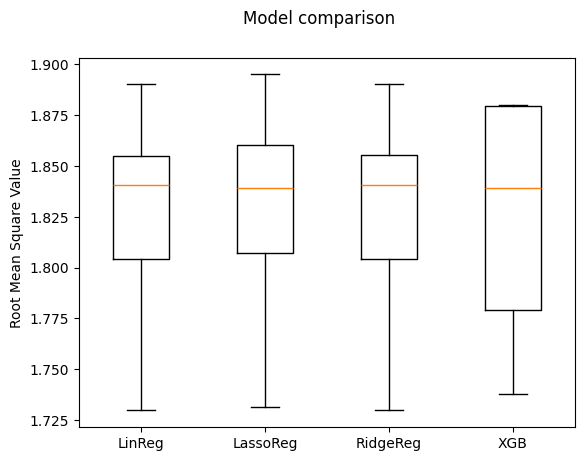

In [346]:
def compare_model_scores(model_names, model_results):
    
    fig = plt.figure()
    fig.suptitle('Model comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(model_results)
    ax.set_xticklabels(model_names)
    ax.set_ylabel("Root Mean Square Value")
    plt.show()

compare_model_scores(model_names, model_results)

Looks like the regression techniques edge out on average, but XGBoost has the possibility of being much better. Let's compare the techniques for transfer selection.

## Transfer Selection

- For each player position, find the player in the current FPL team with the lowest predicted points. Here, I excluded the Keeper since the variance in points (and thus the potential benefit from a transfer) from Keepers is not very high compared to the other positions.

- From the pool of players not in the current team, get all players that (1) have predicted points that are higher than this player, and (2) a cost that is lower than the cost of this player and the current available money. From this pool of players, a potential player will be selected.

- Among the 3 potential players selected (1 from each position), the player with the highest predicted point difference, compared against the player that they will replace, will be selected as the final player to be transferred in.

- The constraint of not more than 3 players from the same team will also be checked.

- There could be cases where all the players from the current team have the highest predicted points for their respective positions. In that case, no transfers will be made.

In [347]:
def make_predicted_table(y_test, y_pred, gw_df):
    results_df = pd.DataFrame(list(zip(y_test.tolist(), y_pred.tolist())),
                             columns=["actual", "predicted"])
    
    results_df.reset_index(drop=True, inplace=True)
    gw_df.reset_index(inplace=True)
    pred_df = pd.concat([gw_df, results_df], axis=1)
    
    return pred_df

In [499]:
def get_suggested_transfer(predicted_df, team_list, current_money):
    
    predicted_diff = 0
    money_change = 0
    suggested_in = ''
    suggested_out = ''
    potential_out_cost = 0
    team_df = predicted_df[(predicted_df.full_name.isin(team_list))]
    
    teams_dict = {}
    for i, row in team_df.iterrows():
        if row.player_team_name not in teams_dict:
            teams_dict[row.player_team_name] = [row.full_name]
        else:
            teams_dict[row.player_team_name].append(row.full_name)
            
    for position in ["Defender", "Midfielder", "Forward"]:
        
        player_df = predicted_df[predicted_df.position_y == position].sort_values('predicted', ascending=False).reset_index()
        
        lowest_pos = 0
        
        player_names = team_df[team_df.position_y == position].full_name.values
        
        for p in player_names:
            player_pos = player_df[player_df.full_name == p].index[0]
            if player_pos > lowest_pos:
                lowest_pos = player_pos
                potential_out = p
                potential_out_cost = team_df[team_df.full_name == p].value.values[0]
                potential_out_team = team_df[team_df.full_name == p].player_team_name.values[0]
                potential_out_predicted = team_df[team_df.full_name == p].predicted.values[0]
        
        potential_players = player_df[:lowest_pos]
        potential_players = potential_players[potential_players.value <= potential_out_cost + current_money]
        potential_players = potential_players[potential_players.minutes > 0]
        
        for i, row in potential_players.iterrows():
            if row.full_name in team_list:
                continue
            
            if row.player_team_name in teams_dict and len(teams_dict[row.player_team_name]) == 3:
                if row.player_team_name != potential_out_team:
                    continue
                
            if row.predicted - potential_out_predicted > predicted_diff:
                predicted_diff = row.predicted - potential_out_predicted
                suggested_in = row.full_name
                suggested_out = potential_out
                money_change = potential_out_cost - row.value
                
    return suggested_in, suggested_out, money_change

def get_score(team_list, gw_df):
    gw_score = gw_df[gw_df.full_name.isin(team_list)].actual.sum() \
        + gw_df[(gw_df.full_name.isin(team_list)) & (gw_df.position_y != 'Keeper')].sort_values("predicted", ascending=False).head(1).actual.values[0]
    return gw_score

def get_performance(team_list, starting_money, gw_list, prediction_df):
    
    current_money = starting_money
    total_score = 0
    
    in_list = []
    out_list = []
    score_list = []
    
    for gw in gw_list:
        gw_df = prediction_df[prediction_df.GW == gw]
        money_change = 0
        suggested_in = ''
        suggested_out = ''
        if gw > 1:
            suggested_in, suggested_out, money_change = get_suggested_transfer(gw_df, team_list, current_money)
            current_money += money_change

            if suggested_in and suggested_out:
                team_list.append(suggested_in)
                team_list.remove(suggested_out)
        
        try:
            gw_score = get_score(team_list, gw_df)
        except:
            pass
        out_list.append(suggested_out)
        in_list.append(suggested_in)
        score_list.append(gw_score)
        total_score += gw_score
        
    out_df = pd.DataFrame({'GW': gw_list,
                          'player_in': in_list,
                          'player_out': out_list,
                          'total_score': score_list})
    
    print(total_score)
    return out_df


## Get predictions for the two best models, Linear Regression and XGBoost

lin_reg = LinearRegression()
lin_reg.fit(X_train_no_na, y_train_no_na)
linreg_predictions = lin_reg.predict(X_test_no_na)


xgb_best.fit(X_train, y_train)
xgb_predictions = xgb_best.predict(X_test)

predicted_df_lin_reg = make_predicted_table(y_test_no_na, linreg_predictions, test_df_no_na[relevant_features + ['full_name', 'GW', 'player_team_name', 'total_points']] )
predicted_df_xgb = make_predicted_table(y_test, xgb_predictions, test_df[relevant_features + ['full_name', 'GW', 'player_team_name', 'total_points']] )

predicted_df_lin_reg = make_predicted_table(y_test_no_na, linreg_predictions, test_df_no_na[relevant_features + ['full_name', 'GW', 'player_team_name', 'total_points']] )
predicted_df_xgb = make_predicted_table(y_test, xgb_predictions, test_df[relevant_features + ['full_name', 'GW', 'player_team_name', 'total_points']] )

In [500]:
captain = get_initial_team(prob, previous_season_player_df).sort_values("total_points", ascending=False).head(1).full_name.values[0]

total_points = current_season_player_df[current_season_player_df.full_name.isin(initial_team_df.full_name)].total_points.sum()
total_points += current_season_player_df[current_season_player_df.full_name==captain].total_points

print("Total points for 23/24 season:", total_points.values[0])

Total points for 23/24 season: 1470


In [501]:
## Linear regression

my_team = list(initial_team_df.full_name)
gameweeks = (test_df.GW).unique()
starting_money = 1000 - bench_cost - initial_team_df.starting_cost.sum()

lin_reg_perf = get_performance(my_team, starting_money, gameweeks,
                   predicted_df_lin_reg)

lin_reg_perf

1742


,GW,player_in,player_out,total_score
0,1,,,44
1,2,kyle_walker,ben_mee,25
2,3,diogo_dalot_teixeira,tyrone_mings,26
3,4,yoane_wissa,ivan_toney,68
4,5,bukayo_saka,gabriel_martinelli_silva,48
5,6,andrew_robertson,kieran_trippier,65
6,7,james_maddison,marcus_rashford,26
7,8,jarrod_bowen,bukayo_saka,32
8,9,trent_alexander_arnold,andrew_robertson,83
9,10,callum_wilson,yoane_wissa,69


In [502]:
## XGBoost


my_team = list(initial_team_df.full_name)
gameweeks = (test_df.GW).unique()
starting_money = 1000 - bench_cost - initial_team_df.starting_cost.sum()

xgb_cv_perf = get_performance(my_team, starting_money, gameweeks,
                   predicted_df_xgb)

1926


In [503]:
xgb_cv_perf

,GW,player_in,player_out,total_score
0,1,,,44
1,2,ollie_watkins,ivan_toney,27
2,3,benjamin_white,ben_mee,29
3,4,malo_gusto,tyrone_mings,69
4,5,james_maddison,gabriel_martinelli_silva,61
5,6,levi_colwill,malo_gusto,73
6,7,micky_van_de_ven,levi_colwill,66
7,8,gabriel_fernando_de_jesus,ollie_watkins,59
8,9,dominic_solanke,gabriel_fernando_de_jesus,73
9,10,virgil_van_dijk,micky_van_de_ven,58
